# PREDICTING NEWSLETTER SUBSCRIPTION USING PLAYTIME AND EXPERIENCE

## Introduction

### Background
Video games are more than just entertainment. Video games provide communities, hobbies, and even research tools for many users. In order to keep players connected and engaged, game developers often send out newsletters with game updates, special events, and new content. But not everyone signs up. As such, we wish to figure out what kinds of players are most likely to subscribe to game newsletters.

One game that remains a staple for all players is a popular sandbox video game known as Minecraft. The game allows players explore, build, and interact in a block-based virtual world.

In this project, we use real data from a Minecraft server run up by researchers at UBC. The dataset includes basic information over players, such as their average playtime, age, and whether they subscribed to the newsletter, etc. By exploring this data, we hope to find patterns that can help predict who’s likely to subscribe—something that could be really useful for game devs trying to better reach their audience.

### Question
Can the total playtime and age predict whether a player subscribes to the newsletter in the Minecraft dataset?

### Data Description
This project will require the use of the `players.csv` dataset which contains a list of all unique players, including data about each player.
The dataset contains 196 observations, and 7 variables.

The variables are structured as follows:

- `experience`: Character: How experienced the player is.
- `subscribe`: Logical: If the player is subscribed to the game newsletter.
- `hashedEmail`: Character: Encrypted email of player.
- `played_hours`: Double: Total number of hours the player has spent playing the game.
- `name`: Character: Name of the player.
- `gender`: Character: Gender of the player.
- `Age`: Double: Age of the player.

### Methods and Results

## Step 1: Loading Libraries and Datasets
We first load the necessary libraries needed and set the height and width for the plots. As well as loading the `players.csv` dataset that we will be using for the rest of the analysis.

In [53]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.plot.width = 10, repr.plot.height = 6)

In [54]:
players <- read_csv("data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


## Step 2: Wrangling and Cleaning Data

In preparation for data analysis, we wrangled and cleaned the data to only contain the necessary variables that are relevant to our analysis.

In [62]:
wrangled_players <- players |>
# Selected only the necessary variables
    select(played_hours, Age, subscribe)|>
# Arranged the played_hours data to start from highest playtime to lowest
    arrange(desc(played_hours))

clean_players <- wrangled_players |>
# Filtered to skip any rows of played_hours and Age that had missing data (N/A)
    filter(!is.na(played_hours), !is.na(Age))|>
# Mutated subscribe to make it into a factor
    mutate(subscribe = as.factor(subscribe))
clean_players

played_hours,Age,subscribe
<dbl>,<dbl>,<fct>
223.1,17,TRUE
218.1,20,TRUE
178.2,19,TRUE
⋮,⋮,⋮
0,20,TRUE
0,17,TRUE
0,17,FALSE


## Step 3: Summarize the Data

In [15]:
summary(clean_players)

  played_hours          Age        subscribe  
 Min.   :  0.000   Min.   : 8.00   FALSE: 52  
 1st Qu.:  0.000   1st Qu.:17.00   TRUE :142  
 Median :  0.100   Median :19.00              
 Mean   :  5.905   Mean   :20.52              
 3rd Qu.:  0.600   3rd Qu.:22.00              
 Max.   :223.100   Max.   :50.00              

## Step 4: Visualizing the Data
To visualize the data, we created two separate histograms to examine the distributions of player age and played hours. This allows us to explore whether there is a relationship between these individual variables and the likelihood of a player subscribing to the newsletter.

# Figure 1: Age and Subscription Histogram

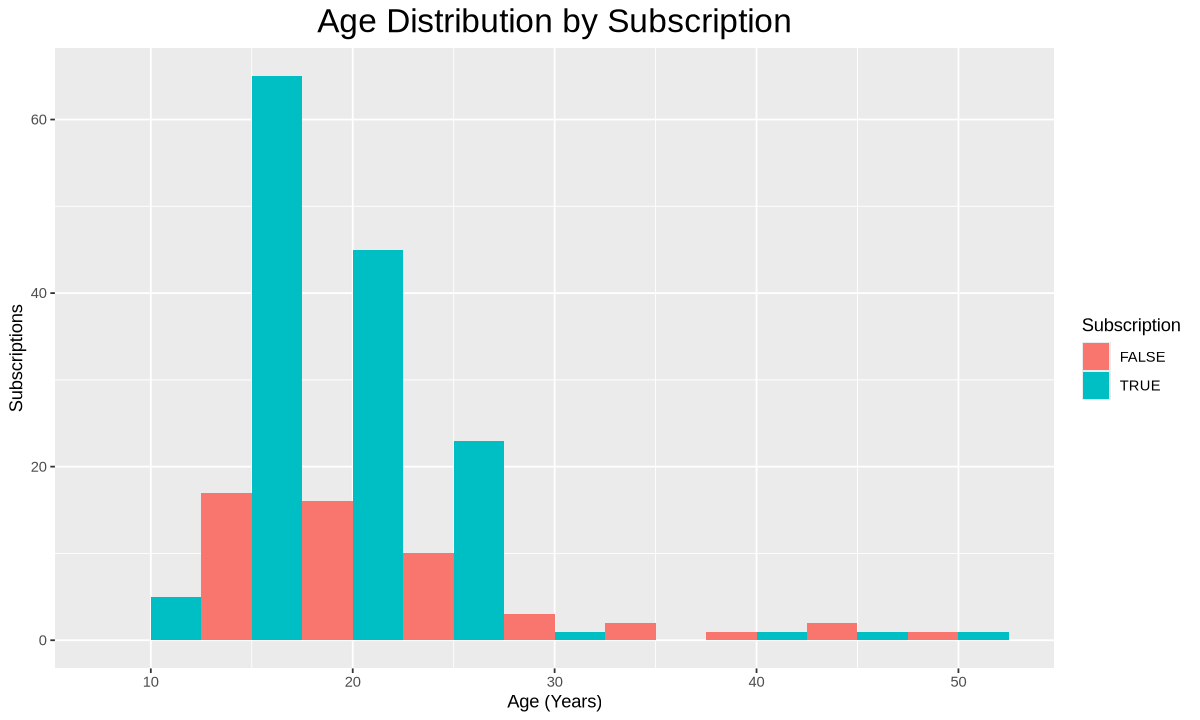

In [51]:
age_plot <- clean_players |>
    ggplot(aes(x=Age, fill=subscribe))+
    geom_histogram(binwidth=5, position="dodge")+
    labs(x="Age (Years)", y="Subscriptions", title="Age Distribution by Subscription", fill="Subscription")+
    theme(plot.title = element_text(size=20, hjust = 0.5))
age_plot

# Figure 2: Playtime and Subscription Histogram

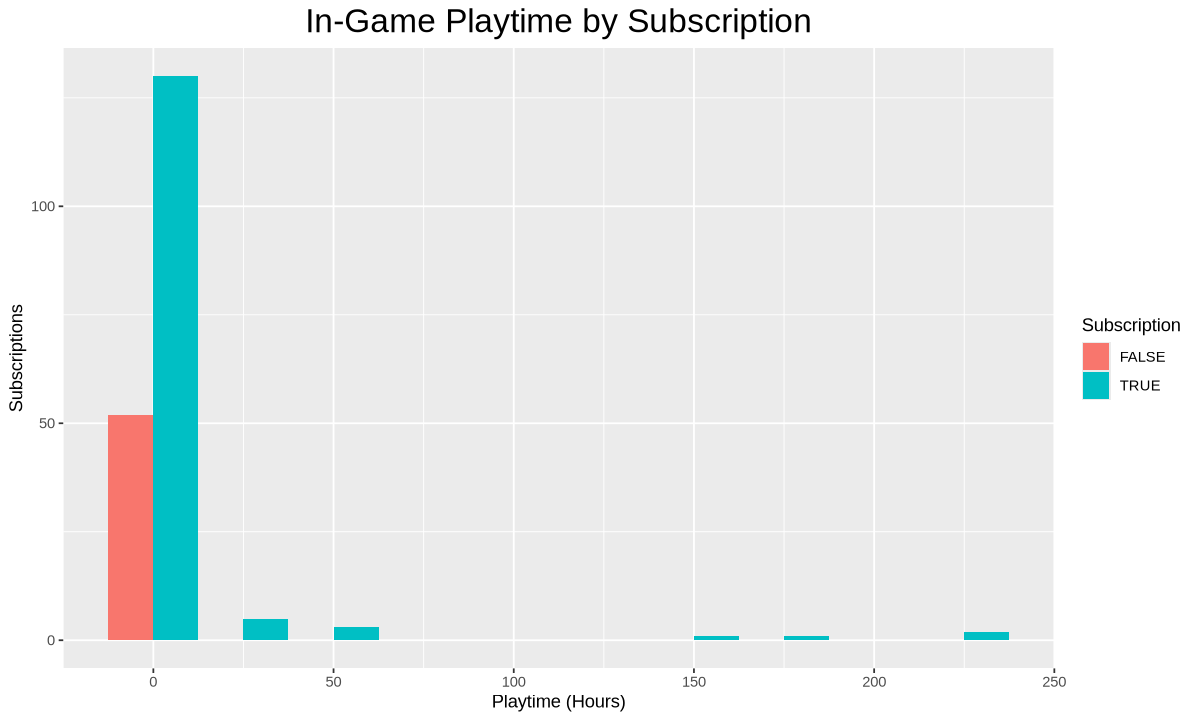

In [52]:
playedhrs_plot <- clean_players |>
    ggplot(aes(x=played_hours, fill=subscribe))+
    geom_histogram(binwidth=25, position="dodge")+
    labs(x="Playtime (Hours)", y="Subscriptions", title="In-Game Playtime by Subscription", fill="Subscription")+
    theme(plot.title = element_text(size=20, hjust = 0.5))
playedhrs_plot

# Main Takeaways From the Histograms
From the age plot:

- The largest age group playing Minecraft is approximately those aged 15-25
- The younger demographic (under 15) are less likely to be subscribed
- The older demographic (over 30) have a more balanced liklihood of being subscribed

From the playtime plot:

- Players with higher playtime tend to subscribe more often
- Nearly every player surpassing a playtime of ~10-20 hours are all subscribed, suggesting a strong positive relationship

## Step 5: Making the Classification Model

To find out whether age and playtime can predict player subscription, the most efficient way to achieve this is to create a K-Nearest Neighbors (KNN) classification model.
A classification model is the best method as it works for both categorical outcomes and numeric predictors, while not assuming a specific data distribution. However, since KNN relies on distance and assumes everything is on similar scales - it will require us to scale everything prior of use. 

Possible limitations using a classification model is its sensitivity to scales, especially with how different the scales Age and played_hrs are and how extreme values can distort KNN's accuracy.

The KNN model proved to be the most efficient compared to other models as methods like linear regression could not be applied as there is no linear pattern. As well as clustering, which would not work as we already know the two groups we want to identify (subscribed or not subscribed).


Firstly, the data `clean_players` is split into 75% training and 25% testing with a 5-fold cross-validation on the training data to tune the model. Then we used a K-Nearest Neighbors (KNN) classification model to predict whether a player would subscribe based on age and playtime (setting up the specifications, recipe, workflow). The model was then tuned for the best number of neighbors, finalized, and fit to the training data.

In [64]:
set.seed(123)
# The data is split into 75% training and 25% testing
data_split <- initial_split(clean_players, prop = 0.75, strata = subscribe)
train_data <- training(data_split)
test_data  <- testing(data_split)

# The 5-fold cross-validation
fold_fold <- vfold_cv( train_data, v=5, strata=subscribe)

# The KNN Specifications
knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("classification")

# The Recipe
p_recipe<- recipe(subscribe ~ ., data= train_data)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

# The Workflow
p_workflow <- workflow()|>
    add_model(knn_spec)|>
    add_recipe(p_recipe)

# Tuning the model
knn_results <- tune_grid(p_workflow, resamples=fold_fold, grid=10, metrics= metric_set(accuracy))

# Selecting the best model
best_k <- select_best(knn_results, metric = "accuracy")
final_model <- finalize_workflow(workflow() |> 
               add_recipe(p_recipe) |> 
               add_model(knn_spec), best_k)

# Fitting everything together
final_fit <- fit(final_model, train_data)
final_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(14L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4
Best kernel: rectangular
Best k: 14